# Import Libraries

In [54]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
pip install tensorflow tensorflow-datasets


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam



# Set the random seed

In [3]:
tf.random.set_seed(42)
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load Data

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Filter to only include the label we need (0, 1)

In [5]:
# Filter labels to only include T shirts (0) and Trousers (1)
train_images = train_images[(train_labels == 0) | (train_labels == 1)]
train_labels = train_labels[(train_labels == 0) | (train_labels == 1)]

test_images = test_images[(test_labels == 0) | (test_labels == 1)]
test_labels = test_labels[(test_labels == 0) | (test_labels == 1)]

train_images = train_images / 255.0
test_images = test_images / 255.0

# EDA

## Visualize the data

In [6]:
class_names = ['T-shirt/top', 'Trouser']

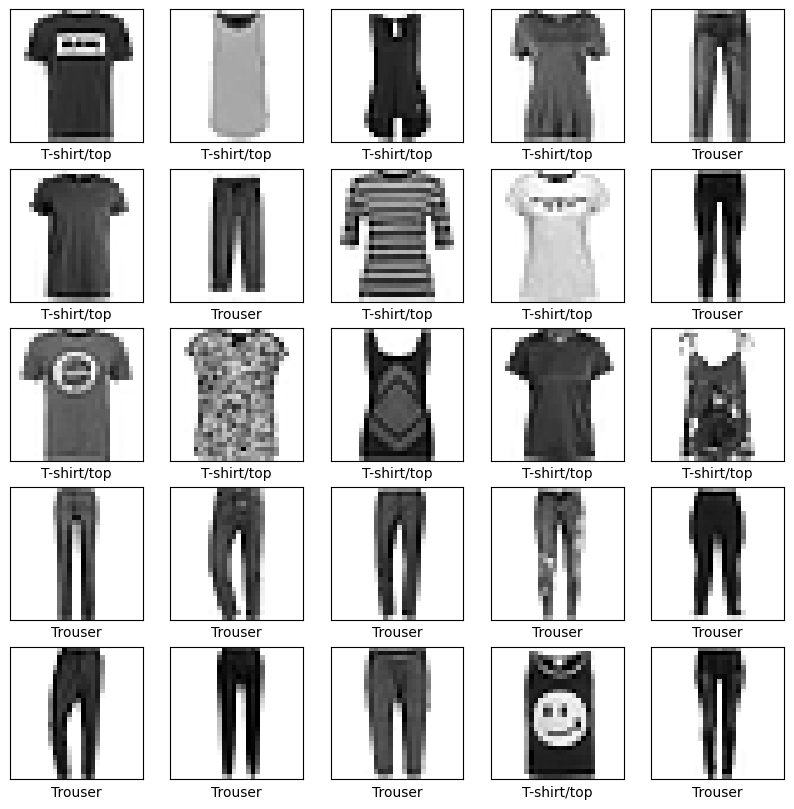

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Preprocess Data

## Reshape the data

In [8]:
train_images = tf.reshape(train_images, (train_images.shape[0], 28, 28, 1))

## Split the data into train, validation, and test sets

In [9]:
# Split the dataset into training and validation sets

train_size = int(0.8 * train_images.shape[0])
train_images, val_images = train_images[:train_size], train_images[train_size:]
train_labels, val_labels = train_labels[:train_size], train_labels[train_size:]

# Split validation set into validation and test sets
val_size = int(0.5 * val_images.shape[0])
val_images, test_images = val_images[:val_size], val_images[val_size:]
val_labels, test_labels = val_labels[:val_size], val_labels[val_size:]

# Base Autoencoder Model

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping

class Autoencoder(Model) :
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # Menentukan input_shape di sini
            MaxPooling2D((14, 14)),
            Flatten(),
            Dense(128, activation='relu')
        ], name='encoder')

        self.decoder = tf.keras.Sequential([
            Dense(6272, activation='relu', input_shape=(128,)),
            Reshape((14, 14, 32)),
            UpSampling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ], name='decoder')
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Compliling Model

In [20]:
base_autoencoder = Autoencoder()
# Autoencoder model summary
base_autoencoder.compile(optimizer='adam', loss='mse')
base_autoencoder.build(train_images.shape)

## Model Summary

In [21]:
abse_autoencoder.get_layer('encoder').summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,544 (17.75 KB)

 Trainable params: 4,544 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
base_autoencoder.get_layer('decoder').summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,625 (3.12 MB)

 Trainable params: 818,625 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [23]:
callabacks = [
    EarlyStopping(monitor='val_loss', patience=3),
]

base_his = base_autoencoder.fit(train_images, train_images, epochs=100, batch_size=128, validation_data=(val_images, val_images), callbacks=callabacks)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1081 - val_loss: 0.0502
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0442 - val_loss: 0.0345
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0328 - val_loss: 0.0318
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0307 - val_loss: 0.0305
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0290 - val_loss: 0.0288
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0284 - val_loss: 0.0283
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0279 - val_loss: 0.0279
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0274 - val_loss: 0.0275
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0270 - val_loss: 0.0271
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0267 - val_loss: 0.0268
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step

## Model Evaluation

### Training Loss VS Validation Loss Plot

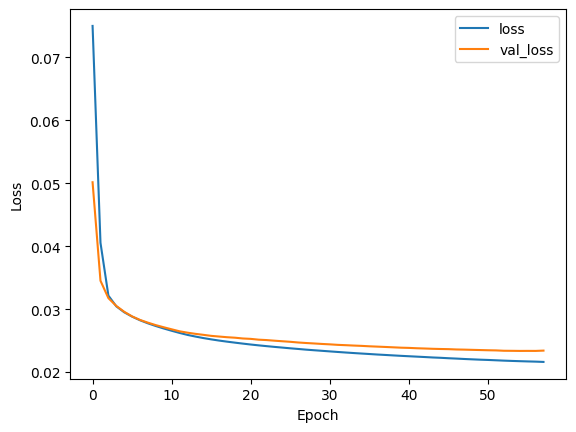

In [24]:
plt.plot(base_his.history['loss'], label='loss')
plt.plot(base_his.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Ada sedikit gap antara training loss dan validation loss, namun gap ini tidak terlalu besar sehingga model ini sedikit overfitting.

### Model Inference

In [25]:
predictions = base_autoencoder.predict(test_images)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


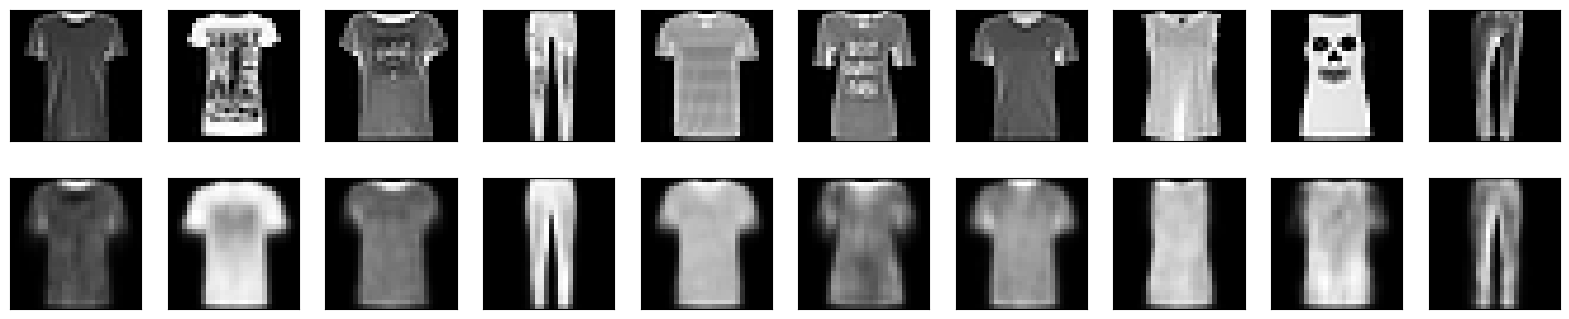

In [26]:
# Show predicted vs original images
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(predictions[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Secara visual hasil rekonstruksi tidak terlalu baik, karena menghilangkan beberapa detail dari gambar asli.

## Save Model

In [27]:
base_autoencoder.save_weights('base_autoencoder.weights.h5')

# Tuned Autoencoder Model

- Use lower learning rate
- Decrease the learning rate
- Decrease the batch size
- Use weight from the base model

## Compliling Model

In [28]:
mod_autoencoder = Autoencoder()

# initialize the model with the base autoencoder weights

mod_autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
mod_autoencoder.build(train_images.shape)
mod_autoencoder.load_weights('base_autoencoder.weights.h5')

c:\Users\Andrew\Python Deep Learning\environments\deep_learning\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Model Summary

In [29]:
mod_autoencoder.get_layer('encoder').summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,544 (17.75 KB)

 Trainable params: 4,544 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
mod_autoencoder.get_layer('decoder').summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,625 (3.12 MB)

 Trainable params: 818,625 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [31]:
callabacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
]

mod_his = mod_autoencoder.fit(train_images, train_images, epochs=100, batch_size=32, validation_data=(val_images, val_images), callbacks=callabacks)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0213 - val_loss: 0.0231
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0212 - val_loss: 0.0231
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0211 - val_loss: 0.0231
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0211 - val_loss: 0.0231
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0211 - val_loss: 0.0231
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0210 - val_loss: 0.0231
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0210 - val_loss: 0.0231
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0210 - val_loss: 0.0231
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0210 - val_loss: 0.0230
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0210 - val_loss: 0.0230
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0209 - val_loss: 0.0230
Epoch 12/100
300/300 ━━━━━━━━━

## Model Evaluation

### Training Loss VS Validation Loss Plot

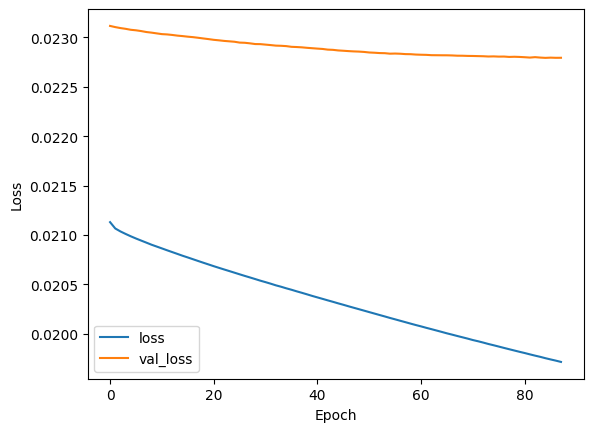

In [32]:
plt.plot(mod_his.history['loss'], label='loss')
plt.plot(mod_his.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Masih terdapat gap antara training loss dan validation loss, namun kita dapat menurunkan validation loss dari model.

### Model Inference

In [33]:
predictions = mod_autoencoder.predict(test_images)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


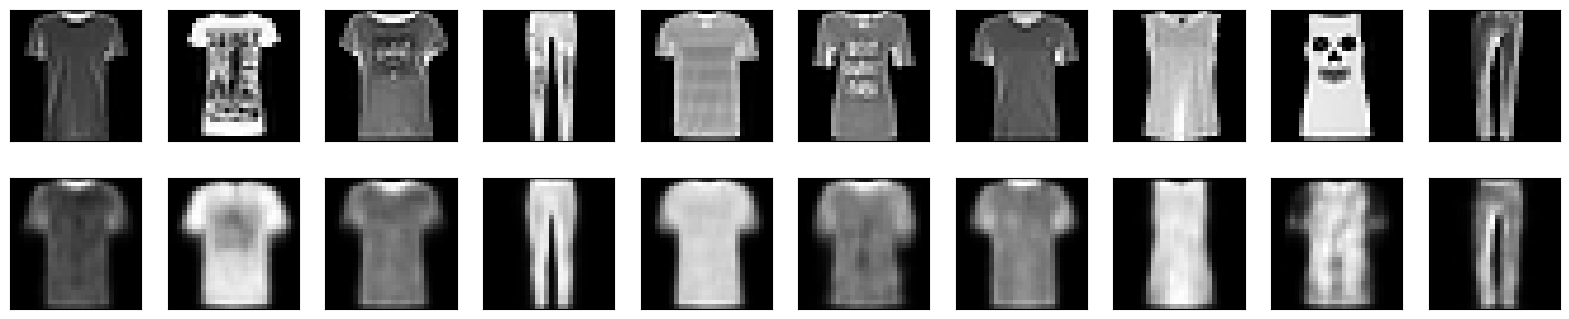

In [ ]:
# Show predicted vs original images
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(predictions[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### SSIM Score

In [34]:
ssim = tf.image.ssim(tf.cast(test_images, tf.double), tf.cast(predictions, tf.double), max_val=1.0)
print(f'Mean SSIM: {tf.reduce_mean(ssim)}')


Mean SSIM: 0.6158570647239685


SSIM dari model ini sudah cukup baik dengan nilai 0.6 yang berarti dimensionality reduction tidak menghilangkan lebih dari 50% informasi dari gambar tetapi hasil gamar rrekonstruksi juga tidak bisa digunakan untuk mentrace back gambal asli. Model ini cocok untuk digunakan dalam image blurring.

LINK VIDIO : https://drive.google.com/drive/folders/17OsVnTnXQ-l2GP-p-oKE7ZNvTqZSHyTl?usp=drive_link